# Regressão Linear Múltipla

O objetivo deste notebook é explorar a regressão múltipla e engenharia de atributos com as funções da API Scikit-learn.

Neste notebook você irá manipular dados de transações imobiliárias de King County para prever preços usando regressão múltipla. Desta forma, você poderá:
* Usar Pandas DataFrames para realizar algumas atividades de engenharia de atributos
* Usar funções do Scikit-learn para computar os coeficientes de regressão (pesos/parâmetros)
* Dados os coeficientes de regressão, os preditores e a saída (preços), criar uma função para computar erro utilizando a técnica de mínimos quadrados (Residual Sum of Squares).
* Visualizar os coeficientes e interpretar seus significados

## Importação das bibliotecas

In [2]:
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


Importação de bibliotecas necessárias para a execução dos comandos:
* Pandas: para manipulação dos dados
* Numpy: para compatibilizar o uso de dados por algumas funções
* Datetime: para formatar um dos atributos da base de dados
* Sklearn: para uso comparativo de funções de regressão linear

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std
from IPython.display import Image, display

### Leitura dos dados

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.

In [82]:
sales = pd.read_csv("kc_house_data.csv")

## Análise Exploratória dos Dados - Exploratory Data Analysis (EDA) e Pré-processamento

In [56]:
sales.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
sales.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [ ]:
#Olhando as duplicatas
print(sales.duplicated().any())
num_duplicatas = sales.duplicated().sum()
print("Número de duplicatas:", num_duplicatas)


False
Número de duplicatas: 0


#### Eliminação manual de atributos que direta ou indiretamente não contribuem para o modelo

Remoção dos atributos *'id' e 'date'*

In [88]:
sales.drop(['id'],axis=1,inplace=True)
sales.drop(['date'],axis=1,inplace=True)

#### Verificação de quantos objetos contém valor igual a ZERO para cada um dos parâmetros

* 4 variáveis com muitos dados com valor igual a zero. Analisando a legenda do dataset isso faz sentido para waterfront e view. Para ano de renovação significa que não foi renovado e para sqft_basement que não possui.

In [ ]:
(sales[sales[sales.columns] == 0]).count()

price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

#### Verificação de quantos valores únicos cada atributo possui
Esta verificação foi realizada para se ter uma visão geral dos intervalos de valores que cada atributo apresenta.

In [ ]:
sales.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

#### Visualização de únicos:

In [ ]:
unicos_bath = sales['bathrooms'].unique()
banheiros=unicos_bath.astype(str)
print("Banheiros : ",banheiros)
unicos_view = sales['view'].unique()
view=unicos_view.astype(str)
print("view: ",view)
unicos_condition = sales['condition'].unique()
condition=unicos_condition.astype(str)
print("Condition: ",condition)
unicos_grade = sales['grade'].unique()
grade=unicos_grade.astype(str)
print("Grade: ",grade)
unicos_zip= sales['zipcode'].unique()
zipcode=unicos_zip.astype(str)
print("Zipcode: ",zipcode)
unicos_waterfront = sales['waterfront'].unique()
waterfront=unicos_waterfront.astype(str)
print("Waterfront: ",waterfront)



Banheiros :  ['1.0' '2.25' '3.0' '2.0' '4.5' '1.5' '2.5' '1.75' '2.75' '3.25' '4.0'
 '3.5' '0.75' '4.75' '5.0' '4.25' '3.75' '0.0' '1.25' '5.25' '6.0' '0.5'
 '5.5' '6.75' '5.75' '8.0' '7.5' '7.75' '6.25' '6.5']
view:  ['0' '3' '4' '2' '1']
Condition:  ['3' '5' '4' '1' '2']
Grade:  ['7' '6' '8' '11' '9' '5' '10' '12' '4' '3' '13' '1']
Zipcode:  ['98178' '98125' '98028' '98136' '98074' '98053' '98003' '98198' '98146'
 '98038' '98007' '98115' '98107' '98126' '98019' '98103' '98002' '98133'
 '98040' '98092' '98030' '98119' '98112' '98052' '98027' '98117' '98058'
 '98001' '98056' '98166' '98023' '98070' '98148' '98105' '98042' '98008'
 '98059' '98122' '98144' '98004' '98005' '98034' '98075' '98116' '98010'
 '98118' '98199' '98032' '98045' '98102' '98077' '98108' '98168' '98177'
 '98065' '98029' '98006' '98109' '98022' '98033' '98155' '98024' '98011'
 '98031' '98106' '98072' '98188' '98014' '98055' '98039']
Waterfront:  ['0' '1']


### Gráficos

#### Distribuição dos preços pela localização

<Axes: title={'center': 'Preços por localização'}, xlabel='long', ylabel='lat'>

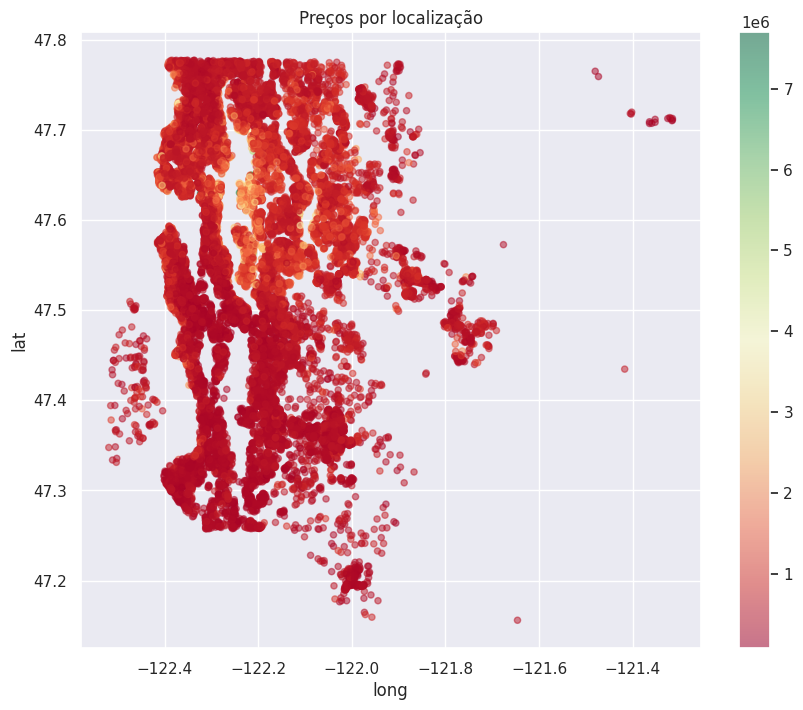

In [ ]:
sales.plot.scatter(y='lat',x='long',c=sales['price'],cmap ='RdYlGn',
                   alpha=0.5, figsize=(10,8),title = "Preços por localização")

Para melhor visualização, outro gráfico foi criado, usando hexbin, que faz a média dos valores do preço dividindo a area em  50x50 hexágonos

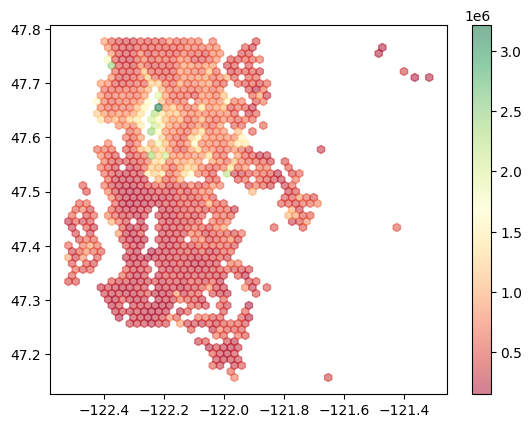

In [7]:
hb =plt.hexbin(x=sales['long'], y=sales['lat'], C=sales['price'], gridsize=50, cmap='RdYlGn', alpha=0.5)
plt.colorbar()


#### Mapa do condado
Visualização do mapa da região para comparação


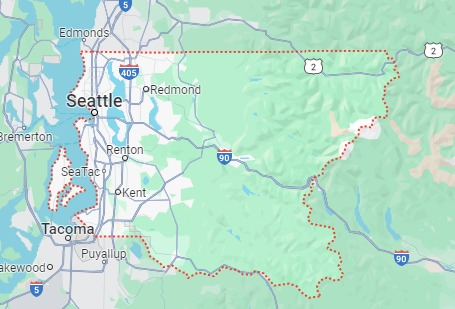

In [ ]:
display(Image(filename='condado.jpeg'))

### Nota da construção e design

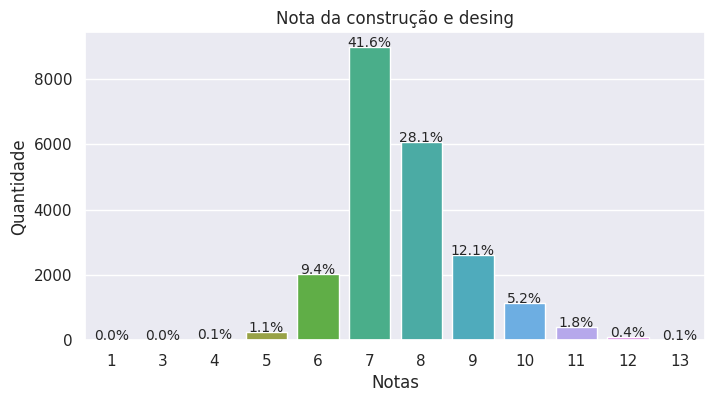

In [9]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(x='grade', data=sales)
total = len(sales['grade'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)
# Adiciona rótulos aos eixos
plt.title('Nota da construção e desing')
plt.xlabel('Notas')
plt.ylabel('Quantidade')

# Exibe o gráfico
plt.show()

Possível ver que não existem notas em 1 e 3 e que a maioria está com nota 7 e 8 que são notas médias, segundo legenda do dataset.
Para melhor visualização será feito um gráfico com intervalo de notas

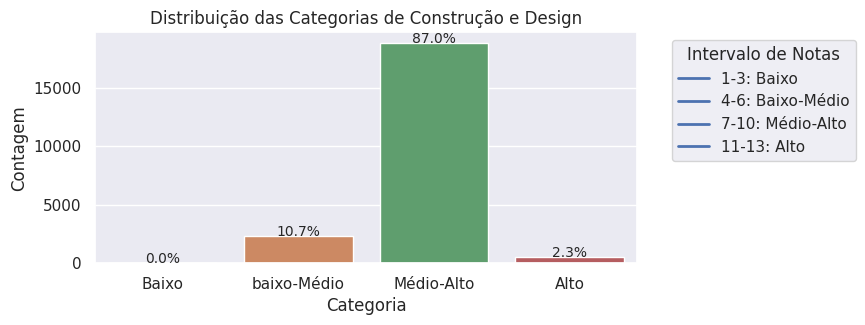

In [22]:
categorias = {
    'Baixo': range(1, 4),
    'baixo-Médio': range(4, 7),
    'Médio-Alto': range(7, 11),
    'Alto': range(11, 14)
}

novo_dataframe = sales.copy()
novo_dataframe['Categoria'] = novo_dataframe['grade'].apply(
    lambda x: next((categoria for categoria, intervalo in categorias.items() if x in intervalo), None)
)

sns.set(rc={'figure.figsize':(7, 3)})

ax = sns.countplot(x='Categoria', data=novo_dataframe , order=['Baixo', 'baixo-Médio', 'Médio-Alto', 'Alto'])

# Adiciona porcentagens em cima das barras
total = len(novo_dataframe['Categoria'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)


plt.title('Distribuição das Categorias de Construção e Design')
plt.xlabel('Categoria')
plt.ylabel('Contagem')

rótulos_personalizados = ['1-3: Baixo', '4-6: Baixo-Médio', '7-10: Médio-Alto', '11-13: Alto']
legendas = [plt.Line2D([0], [0], lw=2) for i in range(len(categorias))]
ax.legend(legendas, rótulos_personalizados, title='Intervalo de Notas', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


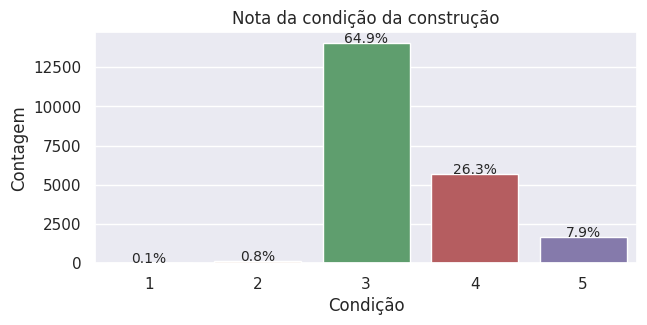

In [11]:
sns.set(rc={'figure.figsize':(7,3)})
ax = sns.countplot(x='condition', data=sales);
total = len(sales['condition'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1,
            f'{height / total:.1%}',
            ha="center",fontsize=10)
plt.title('Nota da condição da construção')

# Adiciona rótulos aos eixos
plt.xlabel('Condição')
plt.ylabel('Contagem')
plt.show()

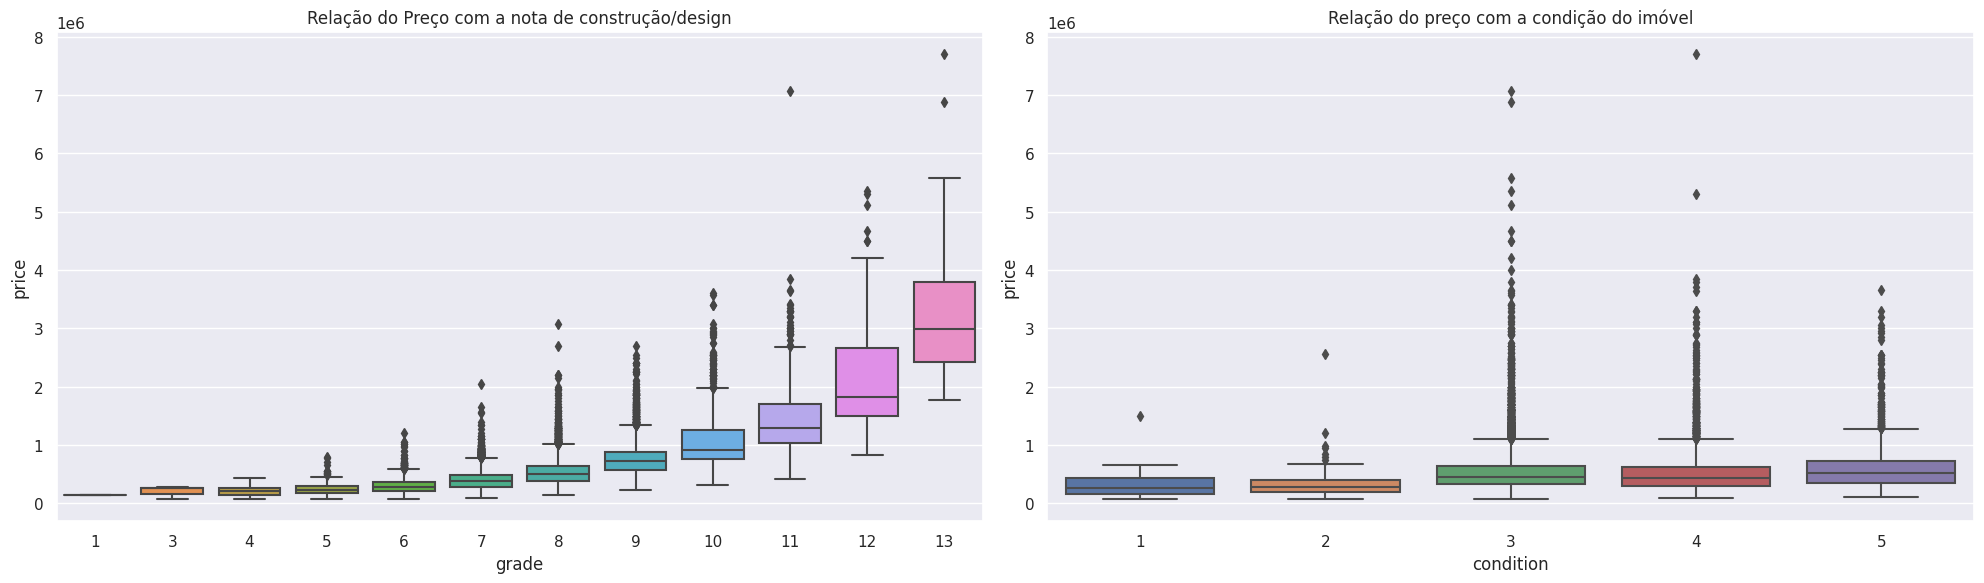

In [12]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.boxplot(x='grade', y='price', data=sales, ax=axes[0])
axes[0].set_title('Relação do Preço com a nota de construção/design')
sns.boxplot(x='condition', y='price', data=sales, ax=axes[1])
axes[1].set_title('Relação do preço com a condição do imóvel')
plt.tight_layout()

plt.show()


Os maiores preços estão nas casas com maiores notas de construção e design, o mesmo ocorreu com a condição, mas na condição 3 existem os maiores valores, apesar da média ser mais baixa

In [13]:
#quantidade de imóveis com e sem vista para o mar
sales["waterfront"].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [ ]:
sales["bedrooms"].value_counts()

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

#### Matriz correlação (apenas das maiores de 0.5)

<ipython-input-14-469cd588200c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacao2 = sales.corr()


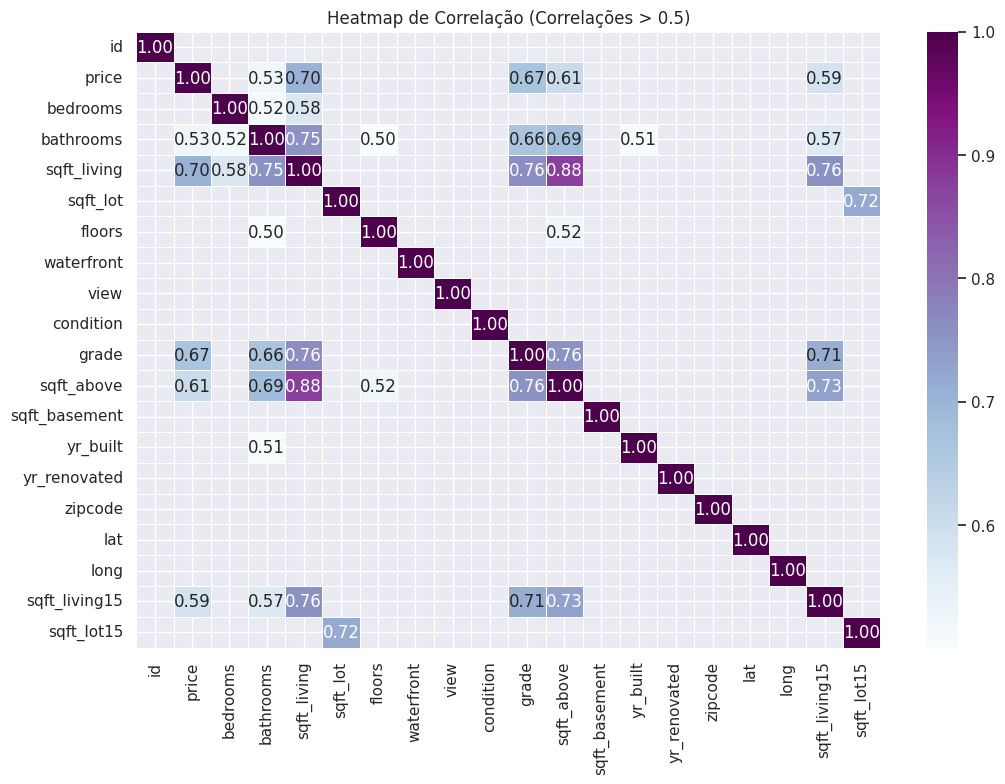

In [14]:
matriz_correlacao2 = sales.corr()

# Filtra as correlações maiores que 0.5
correlacoes_filtradas = matriz_correlacao2[matriz_correlacao2 > 0.5]

# Cria um mapa de calor com as correlações filtradas
plt.figure(figsize=(12, 8))
sns.heatmap(correlacoes_filtradas, annot=True, cmap='BuPu', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlação (Correlações > 0.5)')
plt.show()

In [23]:
colunas = sales.columns.tolist()
colunas

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [24]:
colunas_drop = sales.columns.tolist()
colunas_drop.remove('yr_renovated')
colunas_drop.remove('zipcode')


o yr_renovated foi retirado devido aos zeros, mais abaixo será feito um histograma onde esses valores serão retirados e assim o histograma será coerente. O zipcode também foi retirado, pois não faria sentido olhar o histograma dessa variável

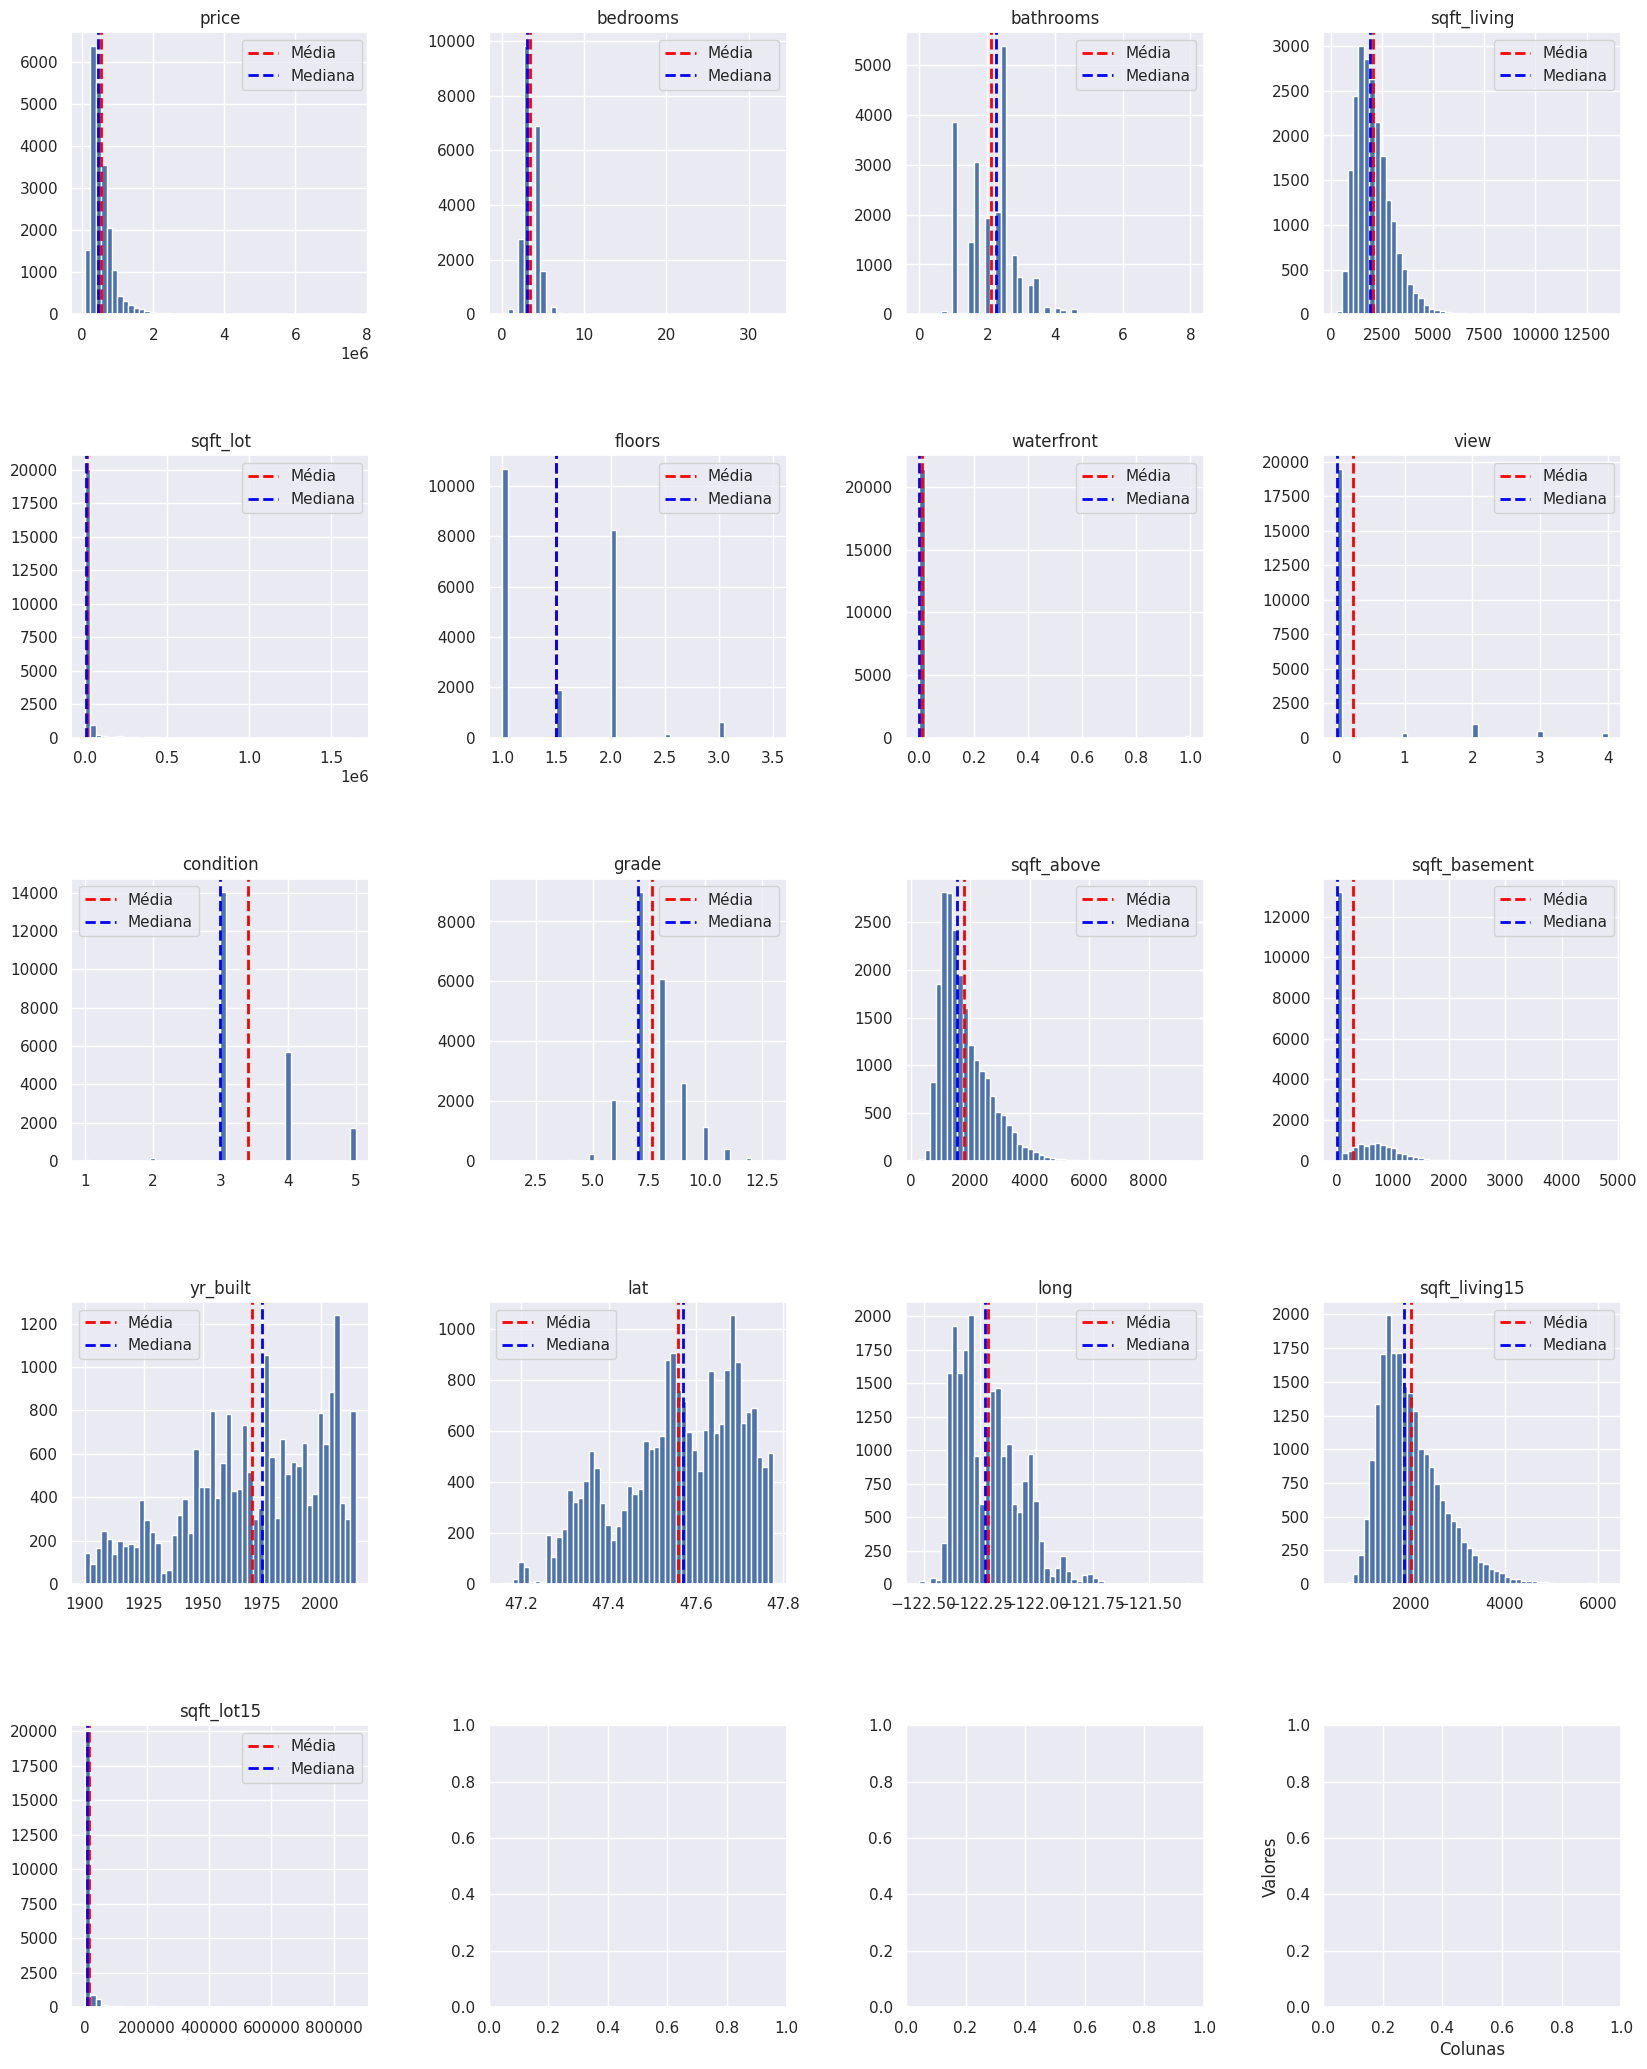

In [25]:

# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas_drop) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas_drop):
    row = i // num_colunas
    coluna = i % num_colunas
    axs[row, coluna].hist(sales[col], bins=50)
    mean_value = sales[col].mean()
    axs[row, coluna].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')

    # Adicione linha vertical para a mediana
    median_value = sales[col].median()
    axs[row, coluna].axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

    axs[row, coluna].set_title(col)
    axs[row, coluna].legend()


# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()


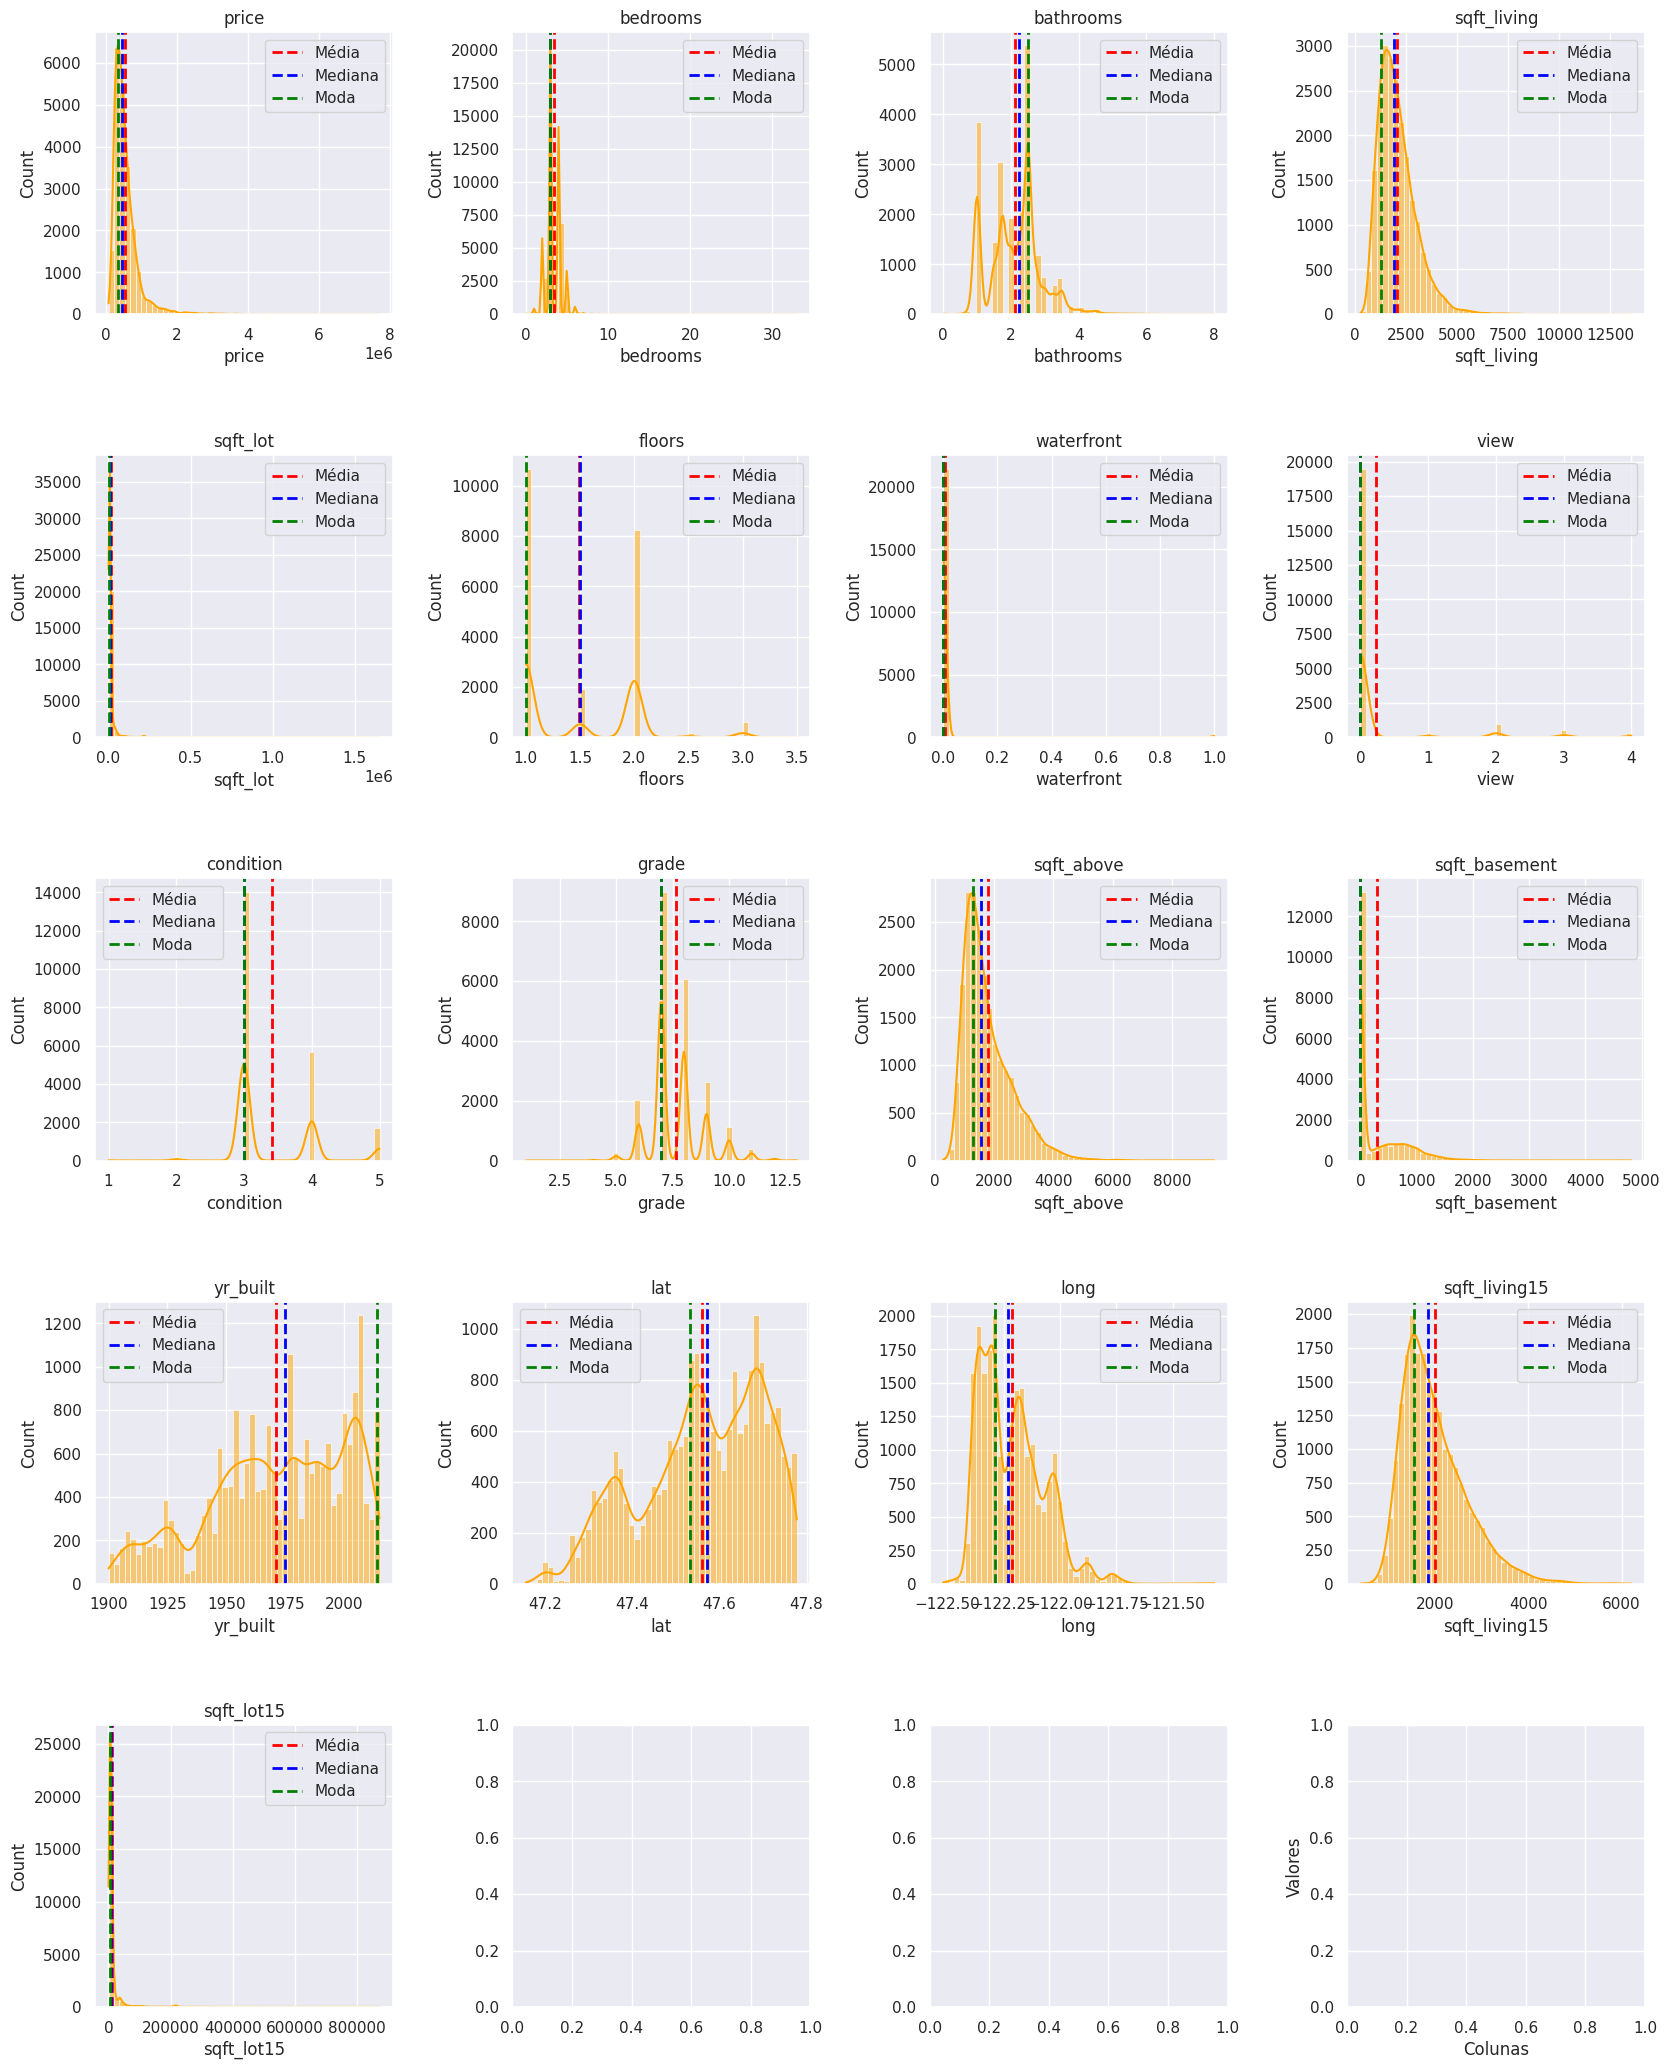

In [26]:

# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas_drop) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas_drop):
    row = i // num_colunas
    coluna = i % num_colunas
    sns.histplot(sales[col], bins=50, kde=True, ax=axs[row, coluna], color='orange')
    # Adicione linha vertical para a média
    mean_value = sales[col].mean()
    axs[row, coluna].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')

    # Adicione linha vertical para a mediana
    median_value = sales[col].median()
    axs[row, coluna].axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

    mode_value = sales[col].mode().iloc[0]  # Pode haver mais de uma moda, escolha a primeira
    axs[row, coluna].axvline(mode_value, color='green', linestyle='dashed', linewidth=2, label='Moda')

    axs[row, coluna].set_title(col)
    axs[row, coluna].legend()


# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()


In [27]:
from scipy.stats import kurtosis


for col in colunas_drop:
    # Calcula a curtose
    curtose = kurtosis(sales[col])

    print(f'Curtose para a coluna {col}: {curtose}')

Curtose para a coluna price: 34.577262255687536
Curtose para a coluna bedrooms: 49.05202582325276
Curtose para a coluna bathrooms: 1.2793287699931106
Curtose para a coluna sqft_living: 5.241602521613769
Curtose para a coluna sqft_lot: 285.01159582778826
Curtose para a coluna floors: -0.48488840505286346
Curtose para a coluna waterfront: 127.602691092139
Curtose para a coluna view: 10.89022423385801
Curtose para a coluna condition: 0.5253643439848448
Curtose para a coluna grade: 1.1903789844878396
Curtose para a coluna sqft_above: 3.4012389779605696
Curtose para a coluna sqft_basement: 2.714668427210353
Curtose para a coluna yr_built: -0.657533026308136
Curtose para a coluna lat: -0.6764341498242992
Curtose para a coluna long: 1.0489805112706225
Curtose para a coluna sqft_living15: 1.5964487608061324
Curtose para a coluna sqft_lot15: 150.72795683083365


### Filtrando o ano de renovação com os valores diferentes de 0

In [67]:
filtered_sales = sales[sales['yr_renovated'] != 0]


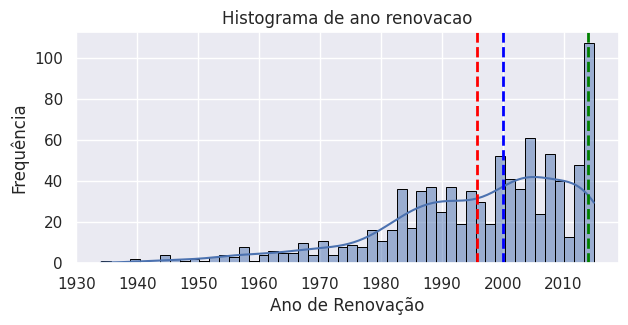

In [29]:
sns.histplot(filtered_sales['yr_renovated'], bins=50, edgecolor='black',kde=True)
mean_value = filtered_sales['yr_renovated'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Média')
median_value = filtered_sales['yr_renovated'].median()
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Mediana')

mode_value = filtered_sales['yr_renovated'].mode().iloc[0]
plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=2, label='Mediana')

plt.title('Histograma de ano renovacao')
plt.xlabel('Ano de Renovação')
plt.ylabel('Frequência')
plt.show()

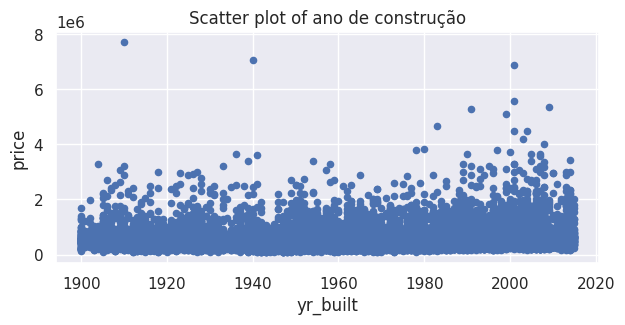

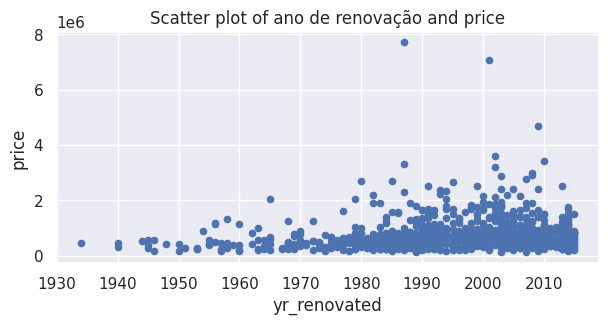

In [30]:
sales.plot.scatter(x='yr_built', y='price', title= 'Scatter plot of ano de construção');
filtered_sales.plot.scatter(x='yr_renovated', y='price', title= 'Scatter plot of ano de renovação and price');

Esses gráficos mostram que as casas mais caras são mais antigas, mas foram renovadas. Abaixo essa consulta é feita no dataframe

In [68]:
filtro_preco_maior_6milhoes = sales['price'] > 6000000
sales[filtro_preco_maior_6milhoes]

id             date      price  bedrooms  bathrooms  \
3914  9808700762  20140611T000000  7062500.0         5       4.50   
7252  6762700020  20141013T000000  7700000.0         6       8.00   
9254  9208900037  20140919T000000  6885000.0         6       7.75   

      sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
3914        10040     37325     2.0           1     2  ...     11        7680   
7252        12050     27600     2.5           0     3  ...     13        8570   
9254         9890     31374     2.0           0     4  ...     13        8860   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3914           2360      1940          2001    98004  47.6500 -122.214   
7252           3480      1910          1987    98102  47.6298 -122.323   
9254           1030      2001             0    98039  47.6305 -122.240   

      sqft_living15  sqft_lot15  
3914           3930       25449  
7252           3940        8800  
9254           4540       42730  

[3 rows x 21 columns]

In [70]:
filtro_areas_grandes = sales['sqft_living'] >10000
sales[filtro_areas_grandes]

id             date      price  bedrooms  bathrooms  \
3914   9808700762  20140611T000000  7062500.0         5        4.5   
7252   6762700020  20141013T000000  7700000.0         6        8.0   
12777  1225069038  20140505T000000  2280000.0         7        8.0   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
3914         10040     37325     2.0           1     2  ...     11   
7252         12050     27600     2.5           0     3  ...     13   
12777        13540    307752     3.0           0     4  ...     12   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
3914         7680           2360      1940          2001    98004  47.6500   
7252         8570           3480      1910          1987    98102  47.6298   
12777        9410           4130      1999             0    98053  47.6675   

          long  sqft_living15  sqft_lot15  
3914  -122.214           3930       25449  
7252  -122.323           3940        8800  
12777 -121.986           4850      217800  

[3 rows x 21 columns]

Outros gráficos:

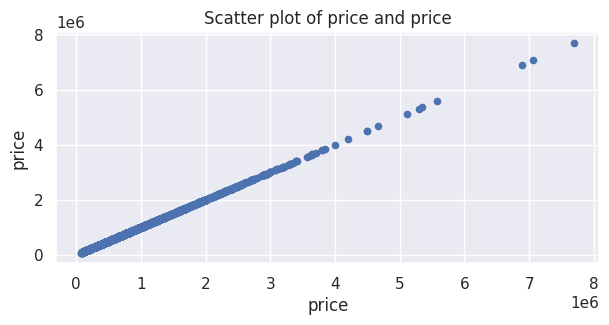

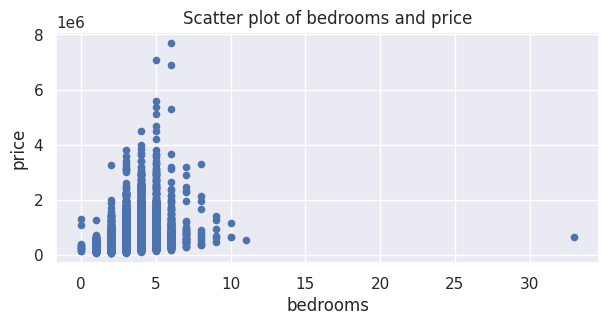

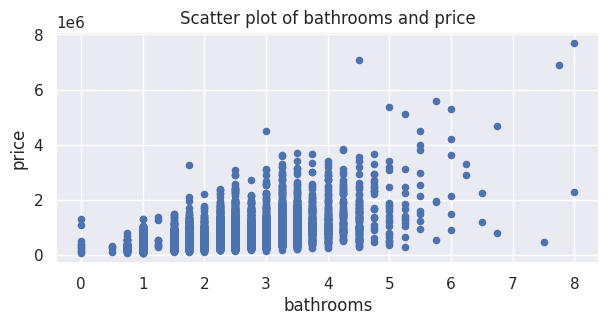

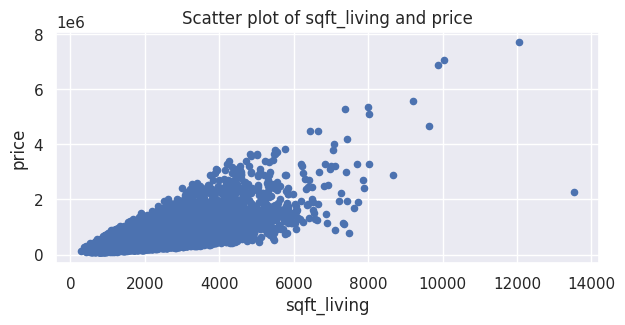

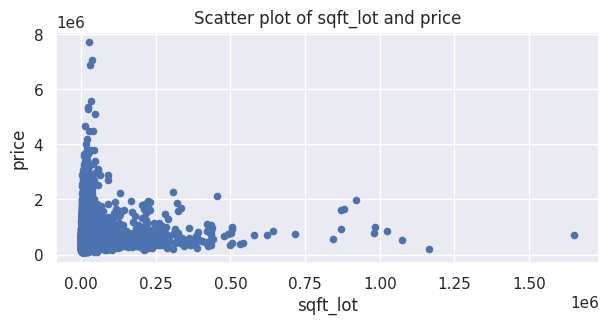

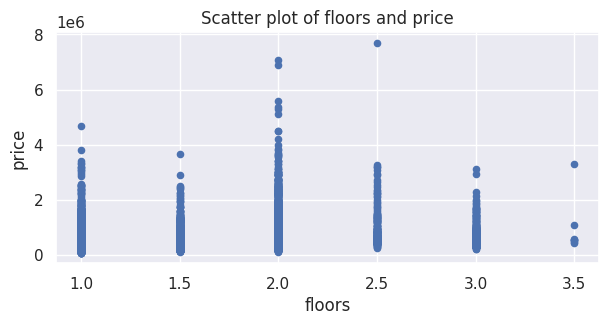

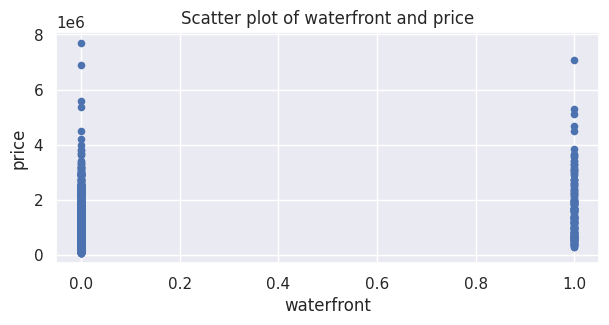

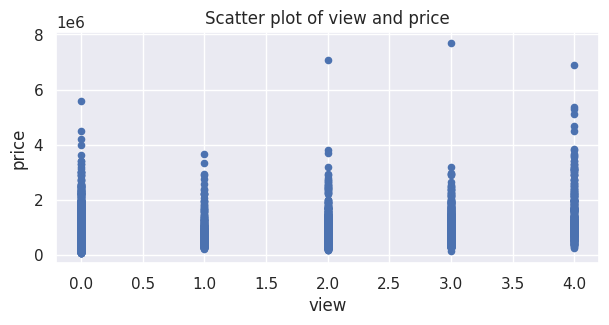

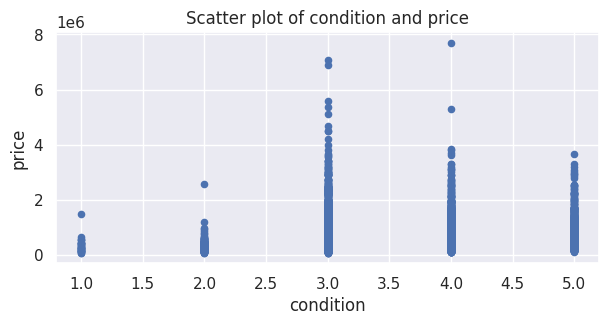

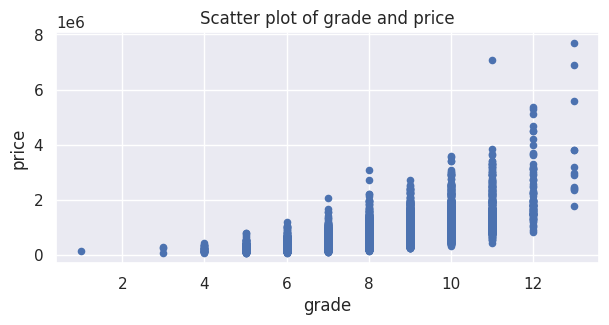

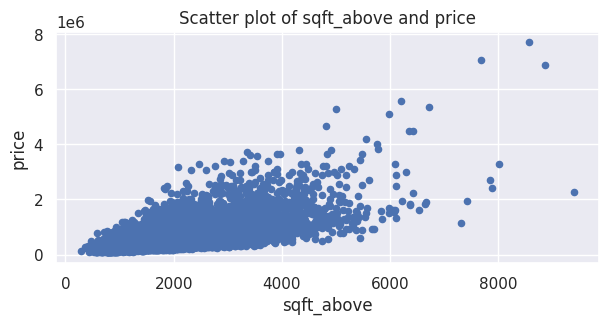

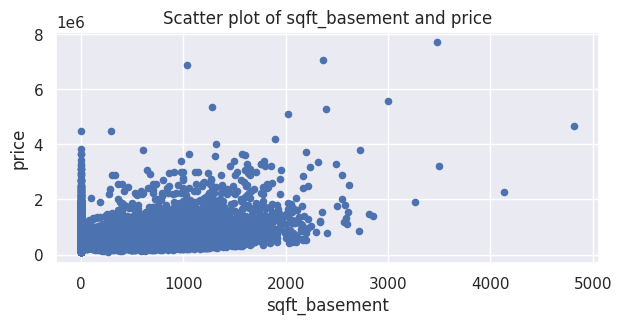

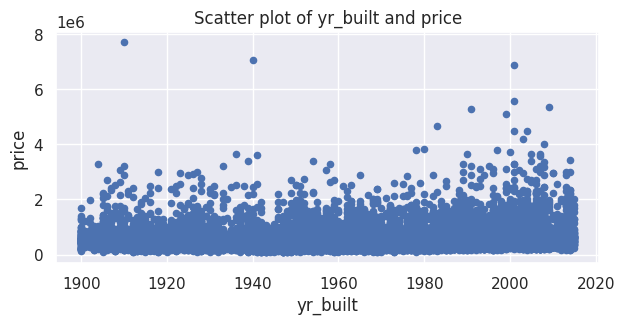

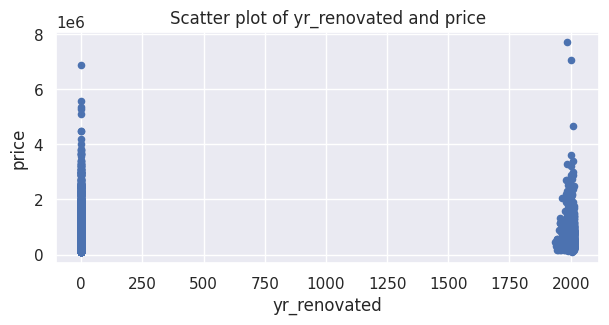

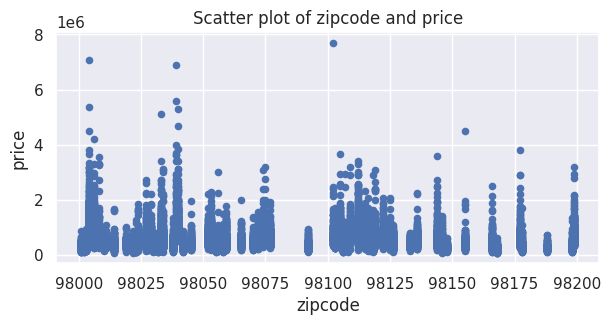

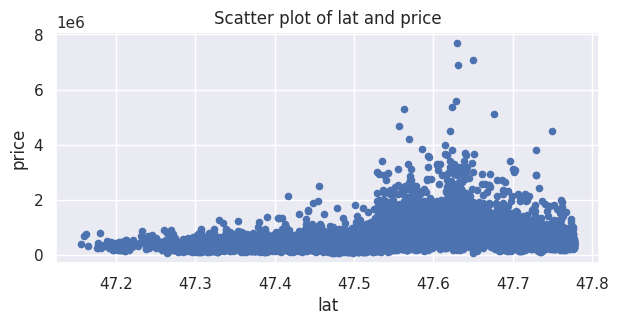

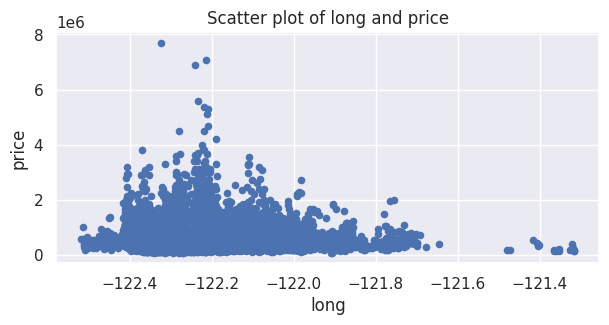

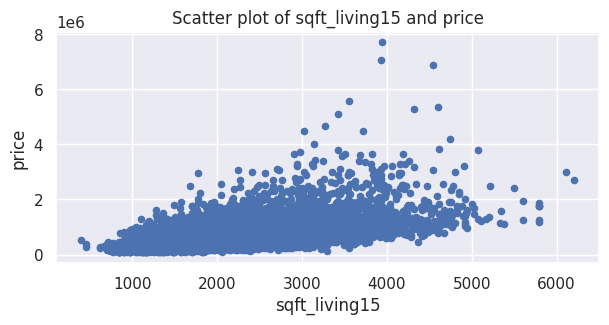

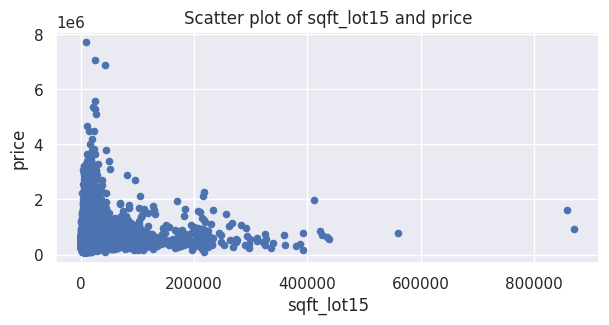

In [ ]:
for col in sales[colunas]:
    sales.plot.scatter(x=col, y='price', title= 'Scatter plot of ' + col + ' and price');

#### Boxplot de todas as variáveis

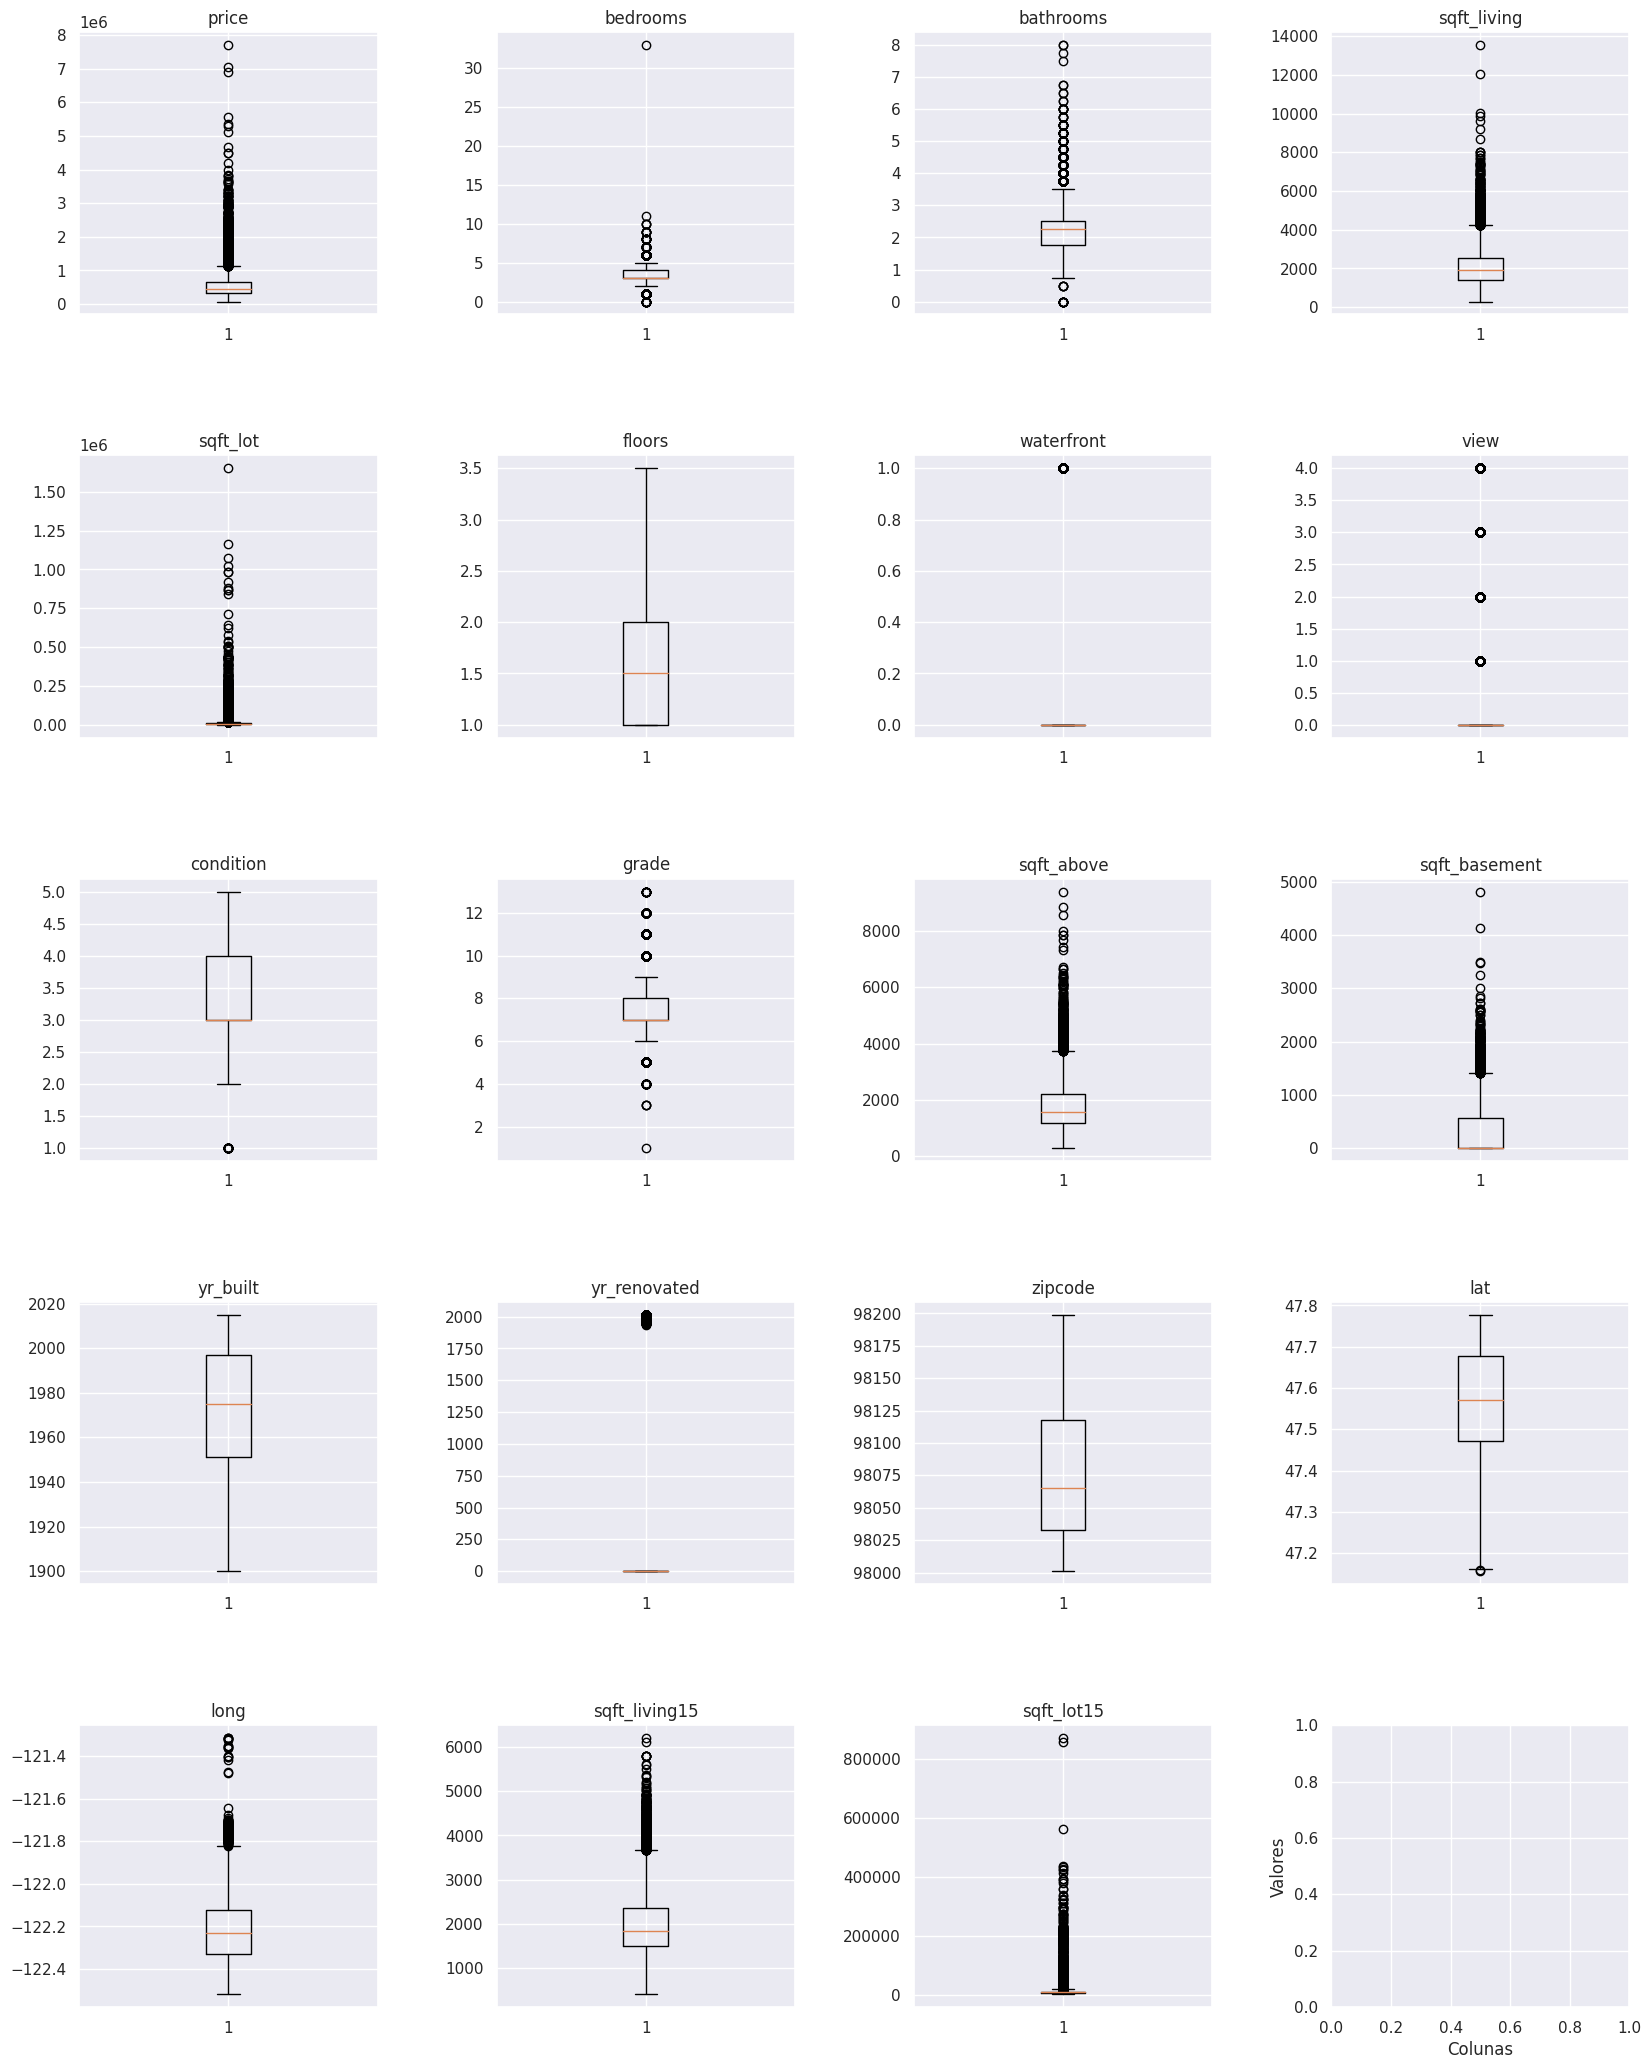

In [31]:
# Configuração dos subplots em 4 por linha
num_linhas = (len(colunas) + 3) // 4  # Arredonda para cima
num_colunas = 4

# Criando subplots
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas))

# Loop para criar boxplots em cada subplot
for i, col in enumerate(colunas):
    row = i // num_colunas
    coluna = i % num_colunas
    axs[row, coluna].boxplot(sales[col])
    axs[row, coluna].set_title(col)

# Adiciona espaço entre os subplots
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.4)

# Adiciona rótulos para os eixos
plt.xlabel('Colunas')
plt.ylabel('Valores')

# Exibe os gráficos
plt.show()

Conforme os gráficos, a quantidade de quartos = 33, parece ser um outliar ao ver que ele é um valor muito alto e o preço da casa não é dos maiores. Pela tabela abaixo da para vermos que a área da casa é pequena, não bate com ter 33 quartos. Por isso esse valor será substituido pela mediana

In [83]:
filtro_33_quartos = sales['bedrooms'] >32
sales[filtro_33_quartos]

id             date     price  bedrooms  bathrooms  \
15870  2402100895  20140625T000000  640000.0        33       1.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
15870         1620      6000     1.0           0     0  ...      7   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
15870        1040            580      1947             0    98103  47.6878   

          long  sqft_living15  sqft_lot15  
15870 -122.331           1330        4700  

[1 rows x 21 columns]

In [84]:
mediana_quartos = sales['bedrooms'].median()
sales.loc[sales['bedrooms'] == 33, 'bedrooms'] = mediana_quartos

Criação de outras colunas no dataframe

In [32]:
# # Mapear valores para categorias
# def categorizar_grade(valor):
#     if valor in range(1, 4):
#         return 'Baixo'
#     elif valor in range(4, 7):
#         return 'Baixo_Médio'
#     elif valor in range(7, 11):
#         return 'Médio-Alta'
#     elif valor in range(11, 14):
#         return 'Alta qualidade'
#     else:
#         return 'Categoria Desconhecida'

# # Criar uma nova coluna 'grade_categorizada'
# sales['grade_categorizada'] = sales['grade'].apply(categorizar_grade)


In [59]:
sales['ano_renovacao_alterado'] = np.where(sales['yr_renovated'] != 0,
                                                           sales['yr_renovated'],
                                                           sales['yr_built'])


In [60]:
sales.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   
2     0          3      6         770              0      1933             0   
3     0          5      7        1050            910      1965             0   
4     0          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  \
0    98178  47.5112 -122.257           1340        5650   
1    98125  47.7210 -122.319           1690        7639   
2    98028  47.7379 -122.233           2720        8062   
3    98136  47.5208 -122.393           1360        5000   
4    98074  47.6168 -122.045           1800        7503   

   ano_renovacao_alterado  
0                    1955  
1                    1991  
2                    1933  
3                    1965  
4                    1987

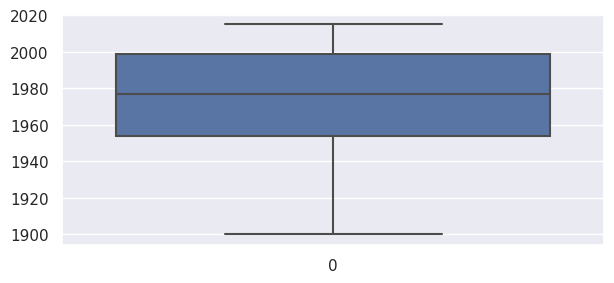

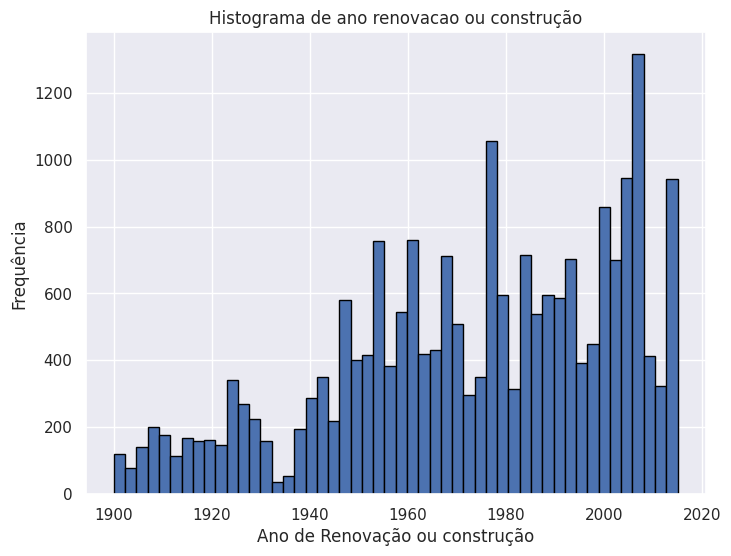

In [35]:
sns.boxplot(sales['ano_renovacao_alterado'])
plt.figure(figsize=(8, 6))
plt.hist(sales['ano_renovacao_alterado'], bins=50, edgecolor='black')
plt.title('Histograma de ano renovacao ou construção')
plt.xlabel('Ano de Renovação ou construção')
plt.ylabel('Frequência')
plt.show()



Gráficos com a Latitude e longitude

<Axes: title={'center': ' yr_built por localização'}, xlabel='long', ylabel='lat'>

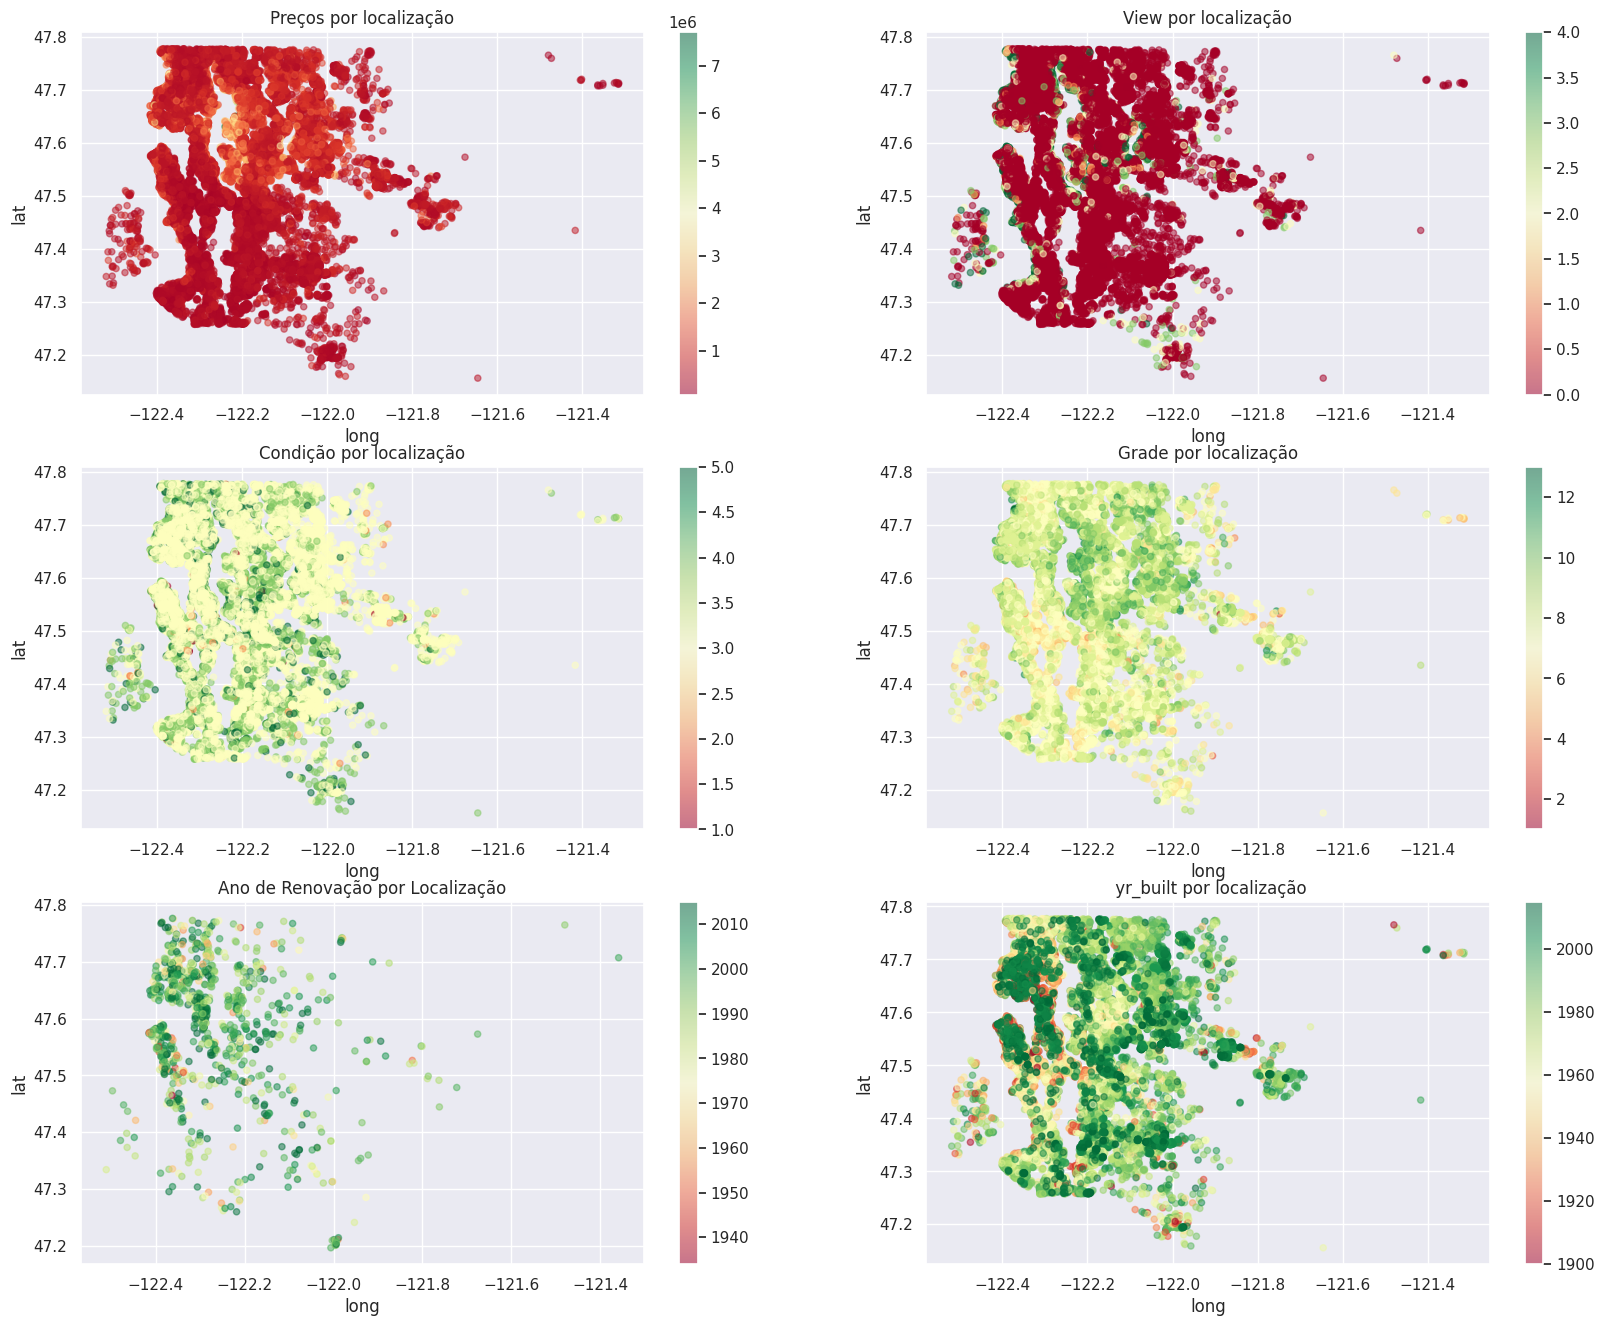

In [61]:
fig, ax=plt.subplots(3,2, figsize=(20,16))
sales.plot.scatter(y='lat',x='long',c=sales['price'],cmap ='RdYlGn',
                   alpha=0.5,title = "Preços por localização",ax=ax[0,0])
sales.plot.scatter(y='lat',x='long',c=sales['view'],cmap ='RdYlGn',
                   alpha=0.5,title = "View por localização",ax=ax[0,1])
sales.plot.scatter(y='lat',x='long',c=sales['condition'],cmap ='RdYlGn',
                   alpha=0.5,title = "Condição por localização",ax=ax[1,0])
sales.plot.scatter(y='lat',x='long',c=sales['grade'],cmap ='RdYlGn',
                   alpha=0.5,title = "Grade por localização",ax=ax[1,1])
filtered_sales = sales[sales['yr_renovated'] != 0]
filtered_sales.plot.scatter(x='long', y='lat', c=filtered_sales['yr_renovated'],
                            cmap='RdYlGn', alpha=0.5, title="Ano de Renovação por Localização", ax=ax[2,0])
sales.plot.scatter(y='lat',x='long',c=sales['yr_built'],cmap ='RdYlGn',
                   alpha=0.5,title = " yr_built por localização",ax=ax[2,1])

<Axes: title={'center': 'Vista para o mar existente por localização'}, xlabel='long', ylabel='lat'>

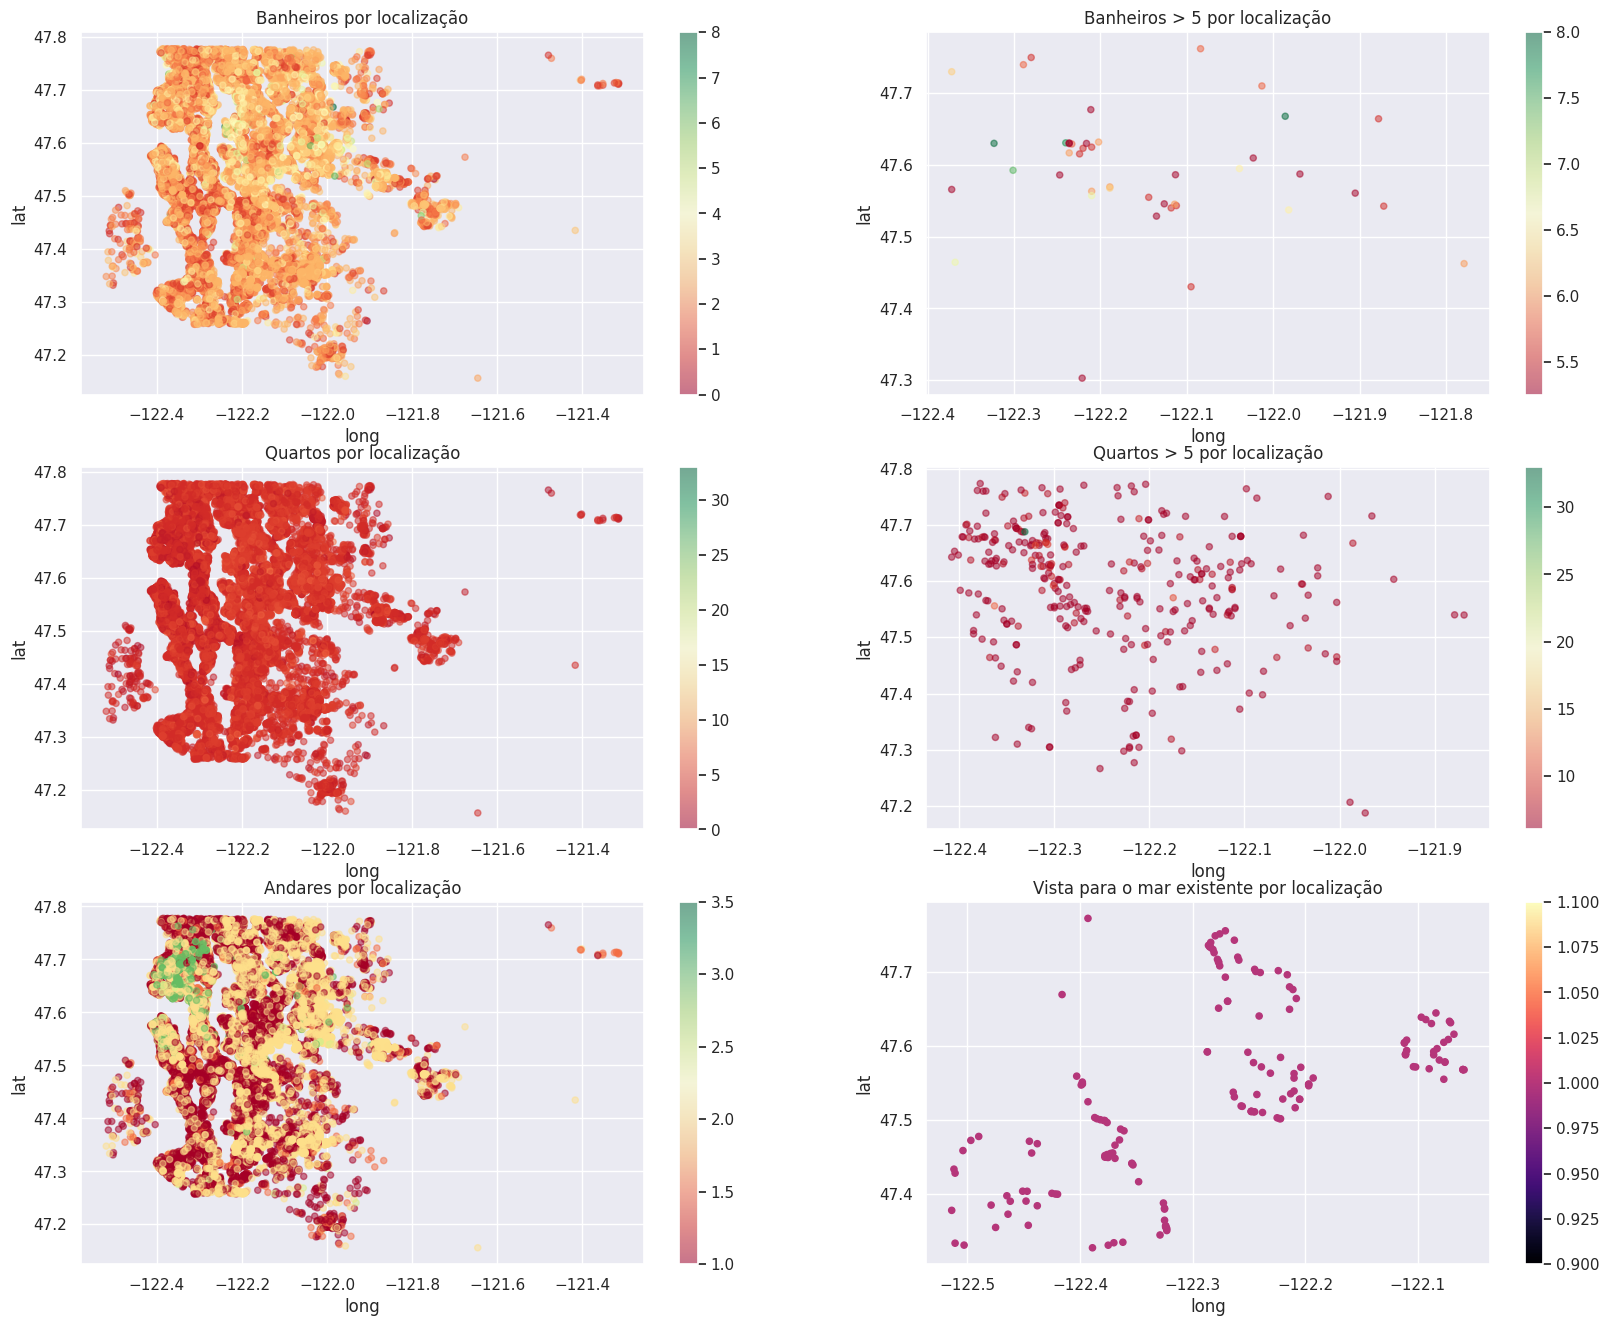

In [37]:
fig, ax=plt.subplots(3,2, figsize=(20,16))
sales.plot.scatter(y='lat',x='long',c=sales['bathrooms'],cmap ='RdYlGn',
                   alpha=0.5,title = "Banheiros por localização",ax=ax[0,0])

filtered_bath = sales[sales['bathrooms'] > 5]
filtered_bath.plot.scatter(x='long', y='lat', c=filtered_bath['bathrooms'],cmap ='RdYlGn',
                            alpha=0.5,title = "Banheiros > 5 por localização",ax=ax[0,1])

sales.plot.scatter(y='lat',x='long',c=sales['bedrooms'],cmap ='RdYlGn',
                   alpha=0.5,title = "Quartos por localização",ax=ax[1,0])
filtered_bed = sales[sales['bedrooms'] > 5]
filtered_bed.plot.scatter(x='long', y='lat', c=filtered_bed['bedrooms'], cmap ='RdYlGn',
                    alpha=0.5,title = "Quartos > 5 por localização",ax=ax[1,1])

sales.plot.scatter(y='lat',x='long',c=sales['floors'], cmap ='RdYlGn',alpha=0.5,
                   title = "Andares por localização",ax=ax[2,0])

filtered_waterfront = sales[sales['waterfront'] !=0]

filtered_waterfront.plot.scatter(y='lat',x='long',c=filtered_waterfront['waterfront'],cmap ='magma'
                   ,title = "Vista para o mar existente por localização",ax=ax[2,1])



### Clusterização ************* ver se mudo

In [85]:
colunas

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


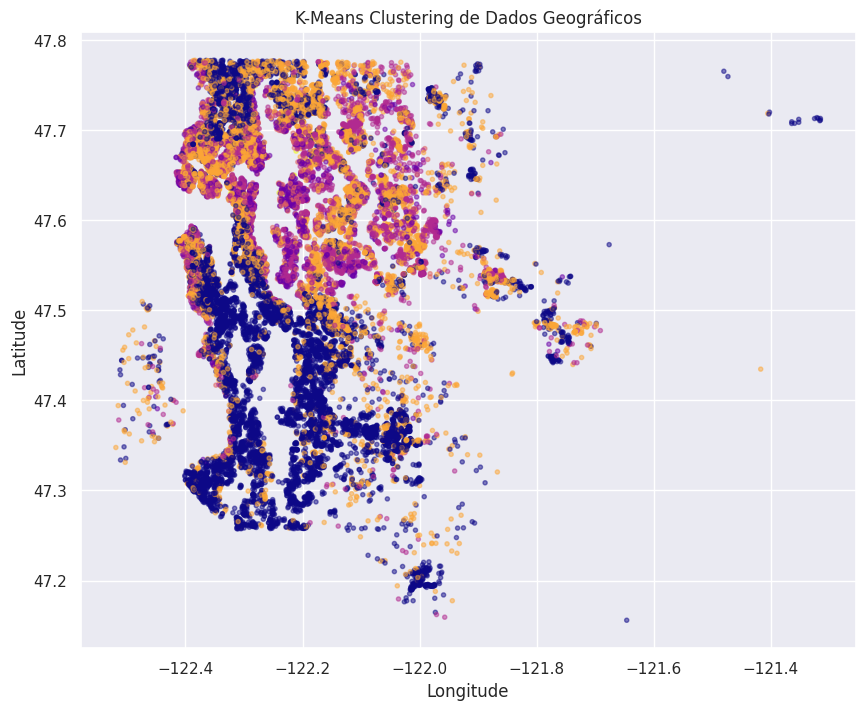

In [44]:

from sklearn.cluster import KMeans


X = sales[['lat', 'long', 'price']]

# Aplicar K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
sales['cluster'] = kmeans.fit_predict(X)

# Visualizar os clusters no mapa
plt.figure(figsize=(10, 8))
plt.scatter(sales['long'], sales['lat'], c=sales['cluster'], cmap='plasma', alpha=0.5,marker='.')
plt.title('K-Means Clustering de Dados Geográficos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

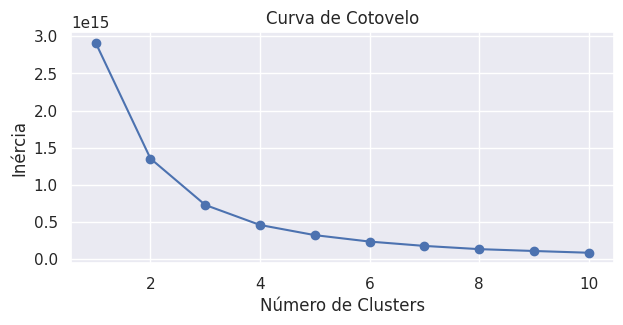

In [45]:
#X = sales[colunas]
X = sales[['lat', 'long', 'price']]
n_clusters_range = range(1, 11)
inertia_values = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotar a curva de cotovelo
plt.plot(n_clusters_range, inertia_values, marker='o')
plt.title('Curva de Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

In [46]:
cluster_stats = sales.groupby('cluster')['price'].describe()
cluster_stats



count          mean           std        min        25%        50%  \
cluster                                                                        
0        9224.0  2.987397e+05  6.929178e+04    75000.0   250000.0   303000.0   
1         943.0  1.439101e+06  2.364885e+05  1135000.0  1245000.0  1379900.0   
2        3615.0  8.283687e+05  1.134432e+05   677790.0   735000.0   800000.0   
3         185.0  2.619759e+06  4.519841e+05  2048000.0  2250000.0  2480000.0   
4        7635.0  5.265522e+05  7.473180e+04   412950.0   460000.0   520500.0   
5          11.0  5.531209e+06  1.174368e+06  4208000.0  4584000.0  5300000.0   

               75%        max  
cluster                        
0         355000.0   412500.0  
1        1600000.0  2027000.0  
2         900000.0  1131000.0  
3        2920000.0  4000000.0  
4         585000.0   677500.0  
5        6227500.0  7700000.0

### Transformação e normalização

In [89]:
features = sales.columns.tolist()
features.remove("price")
X= sales[features]
y = sales["price"]


In [90]:
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [91]:
pd.DataFrame(X['zipcode'])

zipcode
0        98178
1        98125
2        98028
3        98136
4        98074
...        ...
21608    98103
21609    98146
21610    98144
21611    98027
21612    98144

[21613 rows x 1 columns]

In [93]:
zipcode=pd.DataFrame(X['zipcode'])
onehot = OneHotEncoder()
dados = onehot.fit_transform(zipcode[['zipcode']])
zipcode_encoded = pd.DataFrame(dados.toarray(), columns=onehot.get_feature_names_out(), dtype=int)
X = X.drop(['zipcode'], axis=1)
X=X.join(zipcode_encoded)
X

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0             3       1.00         1180      5650     1.0           0     0   
1             3       2.25         2570      7242     2.0           0     0   
2             2       1.00          770     10000     1.0           0     0   
3             4       3.00         1960      5000     1.0           0     0   
4             3       2.00         1680      8080     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21608         3       2.50         1530      1131     3.0           0     0   
21609         4       2.50         2310      5813     2.0           0     0   
21610         2       0.75         1020      1350     2.0           0     0   
21611         3       2.50         1600      2388     2.0           0     0   
21612         2       0.75         1020      1076     2.0           0     0   

       condition  grade  sqft_above  ...  zipcode_98146  zipcode_98148  \
0              3      7        1180  ...              0              0   
1              3      7        2170  ...              0              0   
2              3      6         770  ...              0              0   
3              5      7        1050  ...              0              0   
4              3      8        1680  ...              0              0   
...          ...    ...         ...  ...            ...            ...   
21608          3      8        1530  ...              0              0   
21609          3      8        2310  ...              1              0   
21610          3      7        1020  ...              0              0   
21611          3      8        1600  ...              0              0   
21612          3      7        1020  ...              0              0   

       zipcode_98155  zipcode_98166  zipcode_98168  zipcode_98177  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
21608              0              0              0              0   
21609              0              0              0              0   
21610              0              0              0              0   
21611              0              0              0              0   
21612              0              0              0              0   

       zipcode_98178  zipcode_98188  zipcode_98198  zipcode_98199  
0                  1              0              0              0  
1                  0              0              0              0  
2                  0              0              0              0  
3                  0              0              0              0  
4                  0              0              0              0  
...              ...            ...            ...            ...  
21608              0              0              0              0  
21609              0              0              0              0  
21610              0              0              0              0  
21611              0              0              0              0  
21612              0              0              0              0  

[21613 rows x 87 columns]

In [94]:
#normalização
#ajustando a escala dos dados
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

In [75]:
X

array([[-0.40691262, -1.44746357, -0.97983502, ..., -0.9433552 ,
        -0.26071541, -0.63826626],
       [-0.40691262,  0.1756067 ,  0.53363434, ..., -0.43268619,
        -0.18786773,  0.61146524],
       [-1.50830304, -1.44746357, -1.42625404, ...,  1.07013975,
        -0.17237524, -1.40199107],
       ...,
       [-1.50830304, -1.77207762, -1.15404732, ..., -1.41025258,
        -0.39414129,  1.23633099],
       [-0.40691262,  0.50022075, -0.52252773, ..., -0.8412214 ,
        -0.42051149,  1.06275717],
       [-1.50830304, -1.77207762, -1.15404732, ..., -1.41025258,
        -0.41794772,  1.20161623]])